In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------
# Load datasets
# ------------------------------
crime_rate_df = pd.read_csv("/workspaces/Crime-Prediction-Analysis/Dataset/Crime_Data_2023_Offenses_(With_Lat_&_Long_Info).csv")
unemp_df_2023 = pd.read_csv("/workspaces/Crime-Prediction-Analysis/Dataset/SYRA036URN_2023.csv")

# ------------------------------
# Parse and align date formats
# ------------------------------
crime_rate_df['DATEEND'] = pd.to_datetime(crime_rate_df['DATEEND'], errors='coerce')
crime_rate_df['month'] = crime_rate_df['DATEEND'].dt.to_period('M').dt.to_timestamp()

unemp_df_2023['observation_date'] = pd.to_datetime(unemp_df_2023['observation_date'])
unemp_df_2023.rename(columns={'observation_date': 'month', 'SYRA036URN': 'unemployment_rate'}, inplace=True)

# ------------------------------
# Merge datasets
# ------------------------------
# Merge the first crime dataset and unemployment data
crime_df_2023 = pd.merge(crime_rate_df, unemp_df_2023, on='month', how='left')

# ------------------------------
# Initial cleaning - Removing rows with missing values
# ------------------------------
crime_df_23 = crime_df_2023.drop_duplicates()


# Drop rows where LarcenyCode is missing
crime_df_23 = crime_df_23.dropna(subset=['LarcenyCode'])


# Remove rows with missing values in 'LAT', 'LONG', and 'unemployment_rate'
crime_df_23 = crime_df_23.dropna(subset=['LAT', 'LONG', 'unemployment_rate'])

# Ensure numeric types, removing rows with invalid LAT/LONG
crime_df_23['LAT'] = pd.to_numeric(crime_df_23['LAT'], errors='coerce')
crime_df_23['LONG'] = pd.to_numeric(crime_df_23['LONG'], errors='coerce')

# Remove rows where LAT or LONG are still NaN after coercion
crime_df_23 = crime_df_23.dropna(subset=['LAT', 'LONG'])

# ------------------------------
# Clean 'Arrest' column
# ------------------------------
if 'Arrest' in crime_df_23.columns:
    crime_df_23['Arrest'] = crime_df_23['Arrest'].fillna('NO').astype(str).str.strip().str.upper()

# ------------------------------
# Encode crime type
# ------------------------------
crime_type_col = None
for col in ['CODE DEFINED', 'CODE_DEFINED', 'Crm Cd Desc', 'Crm Cd']:
    if col in crime_df_23.columns:
        crime_type_col = col
        break

if crime_type_col:
    crime_df_23['CrimeType'] = crime_df_23[crime_type_col].astype('category').cat.codes
else:
    crime_df_23['CrimeType'] = -1  # fallback if not found

crime_df_23.to_csv("/workspaces/Crime-Prediction-Analysis/Dataset/crime_df_23_un.csv", index=False)




/tmp/ipykernel_61641/1543950525.py:15: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  crime_rate_df['month'] = crime_rate_df['DATEEND'].dt.to_period('M').dt.to_timestamp()


In [2]:
import pandas as pd
import plotly.express as px

# Load your dataset
crime_df_23 = pd.read_csv('/workspaces/Crime-Prediction-Analysis/Dataset/crime_df_23_un.csv')

# Parse dates
crime_df_23['DATEEND'] = pd.to_datetime(crime_df_23['DATEEND'], errors='coerce')

# Define seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

crime_df_23['Season'] = crime_df_23['DATEEND'].dt.month.apply(get_season)

# Fix column name if needed
if 'CODE DEFINED' in crime_df_23.columns:
    crime_df_23.rename(columns={'CODE DEFINED': 'CODE_DEFINED'}, inplace=True)

# Group data
crime_season_summary = crime_df_23.groupby(['Season', 'CODE_DEFINED']).size().reset_index(name='Crime_Count')

# Sort seasons properly
season_order = ['Spring', 'Summer', 'Fall', 'Winter']
crime_season_summary['Season'] = pd.Categorical(crime_season_summary['Season'], categories=season_order, ordered=True)

# Plot
fig = px.bar(
    crime_season_summary,
    x='Season',
    y='Crime_Count',
    color='CODE_DEFINED',
    title='Crime Type Trends by Season',
    labels={'CODE_DEFINED': 'Crime Type'}
)

fig.update_layout(barmode='stack')
fig.show()


In [3]:
import pandas as pd
import folium
from folium import Popup
from folium.plugins import MarkerCluster

# ---------------------------------------
# Load the dataset
# ---------------------------------------
df = pd.read_csv('/workspaces/Crime-Prediction-Analysis/Dataset/crime_df_23_un.csv')

# Drop rows without location info
df = df.dropna(subset=['LAT', 'LONG'])

# ---------------------------------------
# Define grid boundaries
# ---------------------------------------
lat_min, lat_max = df['LAT'].min(), df['LAT'].max()
lon_min, lon_max = df['LONG'].min(), df['LONG'].max()

# Number of grid divisions
num_lat_grids = 10
num_lon_grids = 10

lat_grid_size = (lat_max - lat_min) / num_lat_grids
lon_grid_size = (lon_max - lon_min) / num_lon_grids

# Assign each record to a grid
def assign_grid(lat, lon):
    lat_idx = int((lat - lat_min) / lat_grid_size)
    lon_idx = int((lon - lon_min) / lon_grid_size)
    lat_idx = min(lat_idx, num_lat_grids - 1)
    lon_idx = min(lon_idx, num_lon_grids - 1)
    return (lat_idx, lon_idx)

df['grid'] = df.apply(lambda row: assign_grid(row['LAT'], row['LONG']), axis=1)

# Summarize by grid
grid_summary = []
for grid_id, group in df.groupby('grid'):
    top_crime = group['CODE_DEFINED'].value_counts().idxmax()
    crime_count = group.shape[0]
    grid_summary.append({
        'grid_id': grid_id,
        'top_crime': top_crime,
        'crime_count': crime_count,
        'lat_idx': grid_id[0],
        'lon_idx': grid_id[1]
    })

grid_summary_df = pd.DataFrame(grid_summary)

# ---------------------------------------
# Create a color mapping for each crime type
# ---------------------------------------
import random

# List of some colors (you can add more if needed)
color_list = [
    'red', 'blue', 'green', 'purple', 'orange', 'darkred', 
    'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 
    'darkpurple', 'pink', 'lightblue', 'lightgreen', 'gray', 'black'
]

unique_crimes = grid_summary_df['top_crime'].unique()
crime_color_mapping = {crime: random.choice(color_list) for crime in unique_crimes}

# ---------------------------------------
# Create the Folium map
# ---------------------------------------
center_lat = (lat_min + lat_max) / 2
center_lon = (lon_min + lon_max) / 2

m = folium.Map(location=[center_lat, center_lon], zoom_start=12, tiles='cartodbpositron')

# Plot grids as rectangles
for idx, row in grid_summary_df.iterrows():
    lat_start = lat_min + row['lat_idx'] * lat_grid_size
    lat_end = lat_start + lat_grid_size
    lon_start = lon_min + row['lon_idx'] * lon_grid_size
    lon_end = lon_start + lon_grid_size
    
    bounds = [[lat_start, lon_start], [lat_end, lon_end]]
    popup_text = f"<b>Top Crime:</b> {row['top_crime']}<br><b>Total Crimes:</b> {row['crime_count']}"
    
    folium.Rectangle(
        bounds=bounds,
        color=crime_color_mapping[row['top_crime']],
        fill=True,
        fill_color=crime_color_mapping[row['top_crime']],
        fill_opacity=0.3,
        popup=folium.Popup(popup_text, max_width=300)
    ).add_to(m)

# Optional: Add all crime points (clustered)
marker_cluster = MarkerCluster().add_to(m)
for idx, crime in df.iterrows():
    folium.Marker(
        location=[crime['LAT'], crime['LONG']],
        popup=folium.Popup(f"{crime['CODE_DEFINED']}", max_width=200)
    ).add_to(marker_cluster)

# Save to file
m.save('Syracuse_Crime_Grid_Map_Colored.html')
print("✅ Interactive colored map saved as Syracuse_Crime_Grid_Map_Colored.html")


✅ Interactive colored map saved as Syracuse_Crime_Grid_Map_Colored.html


In [4]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Load data
df = pd.read_csv('/workspaces/Crime-Prediction-Analysis/Dataset/crime_df_23_un.csv')

# Fix TIMESTART to get hour
df['TIMESTART'] = df['TIMESTART'].astype(str).str.zfill(4)
df['hour'] = df['TIMESTART'].str[:2].astype(int)

# Parse date for day of week and month name
df['DATEEND'] = pd.to_datetime(df['DATEEND'])
df['day_of_week'] = df['DATEEND'].dt.dayofweek
df['month_name'] = df['DATEEND'].dt.strftime('%B')  # Month name like 'January'

# Dropdown options
crime_types = df['CODE_DEFINED'].unique()
months = df['month_name'].unique()

crime_dropdown = widgets.Dropdown(
    options=['All'] + sorted(list(crime_types)),
    value='All',
    description='Crime Type:',
)

month_dropdown = widgets.Dropdown(
    options=['All'] + sorted(list(months), key=lambda x: pd.to_datetime(x, format='%B').month),
    value='All',
    description='Month:',
)

# Function to update heatmap
def update_heatmap(crime_type, month):
    temp_df = df.copy()
    
    if crime_type != 'All':
        temp_df = temp_df[temp_df['CODE_DEFINED'] == crime_type]
    
    if month != 'All':
        temp_df = temp_df[temp_df['month_name'] == month]
    
    # Create full 7x24 grid
    all_days = list(range(7))  # Monday = 0
    all_hours = list(range(24))  # 0-23
    full_grid = pd.MultiIndex.from_product([all_days, all_hours], names=['day_of_week', 'hour']).to_frame(index=False)

    # Group by actual crimes
    crime_counts = temp_df.groupby(['day_of_week', 'hour']).size().reset_index(name='crime_count')

    # Merge so all (day, hour) pairs exist
    merged = pd.merge(full_grid, crime_counts, on=['day_of_week', 'hour'], how='left')
    merged['crime_count'] = merged['crime_count'].fillna(0)

    # Pivot table for heatmap
    pivot_table = merged.pivot(index='day_of_week', columns='hour', values='crime_count')

    # Plot heatmap
    plt.figure(figsize=(18, 8))
    sns.heatmap(pivot_table, annot=True, fmt='.0f', cmap='YlOrRd', linewidths=0.5, linecolor='white')

    title = 'Hourly Crime Distribution'
    if crime_type != 'All':
        title += f' for {crime_type}'
    if month != 'All':
        title += f' ({month})'
    
    plt.title(title, fontsize=18)
    plt.xlabel('Hour of Day', fontsize=14)
    plt.ylabel('Day of Week', fontsize=14)

    plt.yticks(
        ticks=[0, 1, 2, 3, 4, 5, 6],
        labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
        rotation=0
    )
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Connect widgets to function
widgets.interact(update_heatmap, crime_type=crime_dropdown, month=month_dropdown);



interactive(children=(Dropdown(description='Crime Type:', options=('All', 'AGGRAVATED ASSAULT', 'BURGLARY', 'L…

/tmp/ipykernel_61641/4005038468.py:19: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.

/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.

/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



✅ Monthly crimes prepared:
month
2022-12-01      3
2023-01-01    303
2023-02-01    336
2023-03-01    310
2023-04-01    331
2023-05-01    366
2023-06-01    349
2023-07-01    558
2023-08-01    608
2023-09-01    574
2023-10-01    558
2023-11-01    509
2023-12-01    381
Freq: MS, dtype: int64
✅ Model fitted successfully.


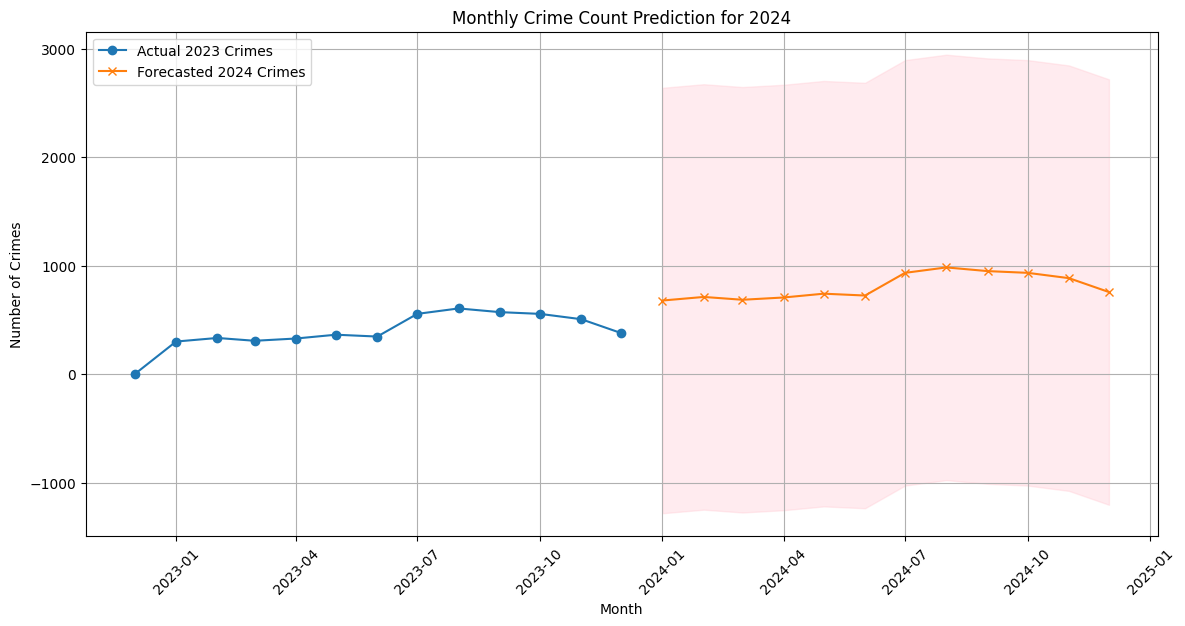

📊 Predicted number of crimes in 2024 by month:
                     Month  Predicted Crimes
2024-01-01    January 2024               681
2024-02-01   February 2024               714
2024-03-01      March 2024               688
2024-04-01      April 2024               709
2024-05-01        May 2024               744
2024-06-01       June 2024               727
2024-07-01       July 2024               936
2024-08-01     August 2024               986
2024-09-01  September 2024               952
2024-10-01    October 2024               936
2024-11-01   November 2024               887
2024-12-01   December 2024               759


In [5]:
# --------------------------------
# 1. Import libraries
# --------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

# --------------------------------
# 2. Load and prepare data
# --------------------------------
# Load your dataset
merged_df = pd.read_csv('/workspaces/Crime-Prediction-Analysis/Dataset/crime_df_23_un.csv')

# Parse dates
merged_df['DATEEND'] = pd.to_datetime(merged_df['DATEEND'], errors='coerce')

# Group data by Month
merged_df['month'] = merged_df['DATEEND'].dt.to_period('M')
monthly_crimes = merged_df.groupby('month').size()

# Convert period to datetime for forecasting
monthly_crimes.index = monthly_crimes.index.to_timestamp()

print("✅ Monthly crimes prepared:")
print(monthly_crimes)

# --------------------------------
# 3. Build the model (SARIMA)
# --------------------------------
# SARIMA is good because it can handle seasonality (months)

# Split into train/test (but here we train fully on 2023 for future prediction)
train = monthly_crimes

# Build SARIMA model (simple seasonal ARIMA)
model = SARIMAX(train,
                order=(1,1,1),        # (p,d,q)
                seasonal_order=(1,1,1,12),  # (P,D,Q,s) — s=12 for monthly seasonality
                enforce_stationarity=False,
                enforce_invertibility=False)

model_fit = model.fit(disp=False)
print("✅ Model fitted successfully.")

# --------------------------------
# 4. Forecast for 2024
# --------------------------------
forecast_steps = 12  # predict 12 months into future

forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start='2024-01-01', periods=12, freq='MS')
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# --------------------------------
# 5. Plot results
# --------------------------------
plt.figure(figsize=(12, 6))
plt.plot(monthly_crimes.index, monthly_crimes.values, label='Actual 2023 Crimes', marker='o')
plt.plot(forecast_index, forecast_mean, label='Forecasted 2024 Crimes', marker='x')

# Confidence Interval 
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)

plt.title('Monthly Crime Count Prediction for 2024')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

# --------------------------------
# 6. Print 2024 predicted crime numbers
# --------------------------------
forecast_summary = pd.DataFrame({
    'Month': forecast_index.strftime('%B %Y'),
    'Predicted Crimes': forecast_mean.round().astype(int)
})
print("📊 Predicted number of crimes in 2024 by month:")
print(forecast_summary)

In [6]:
# Load Data 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------
# Load datasets
# ------------------------------
crime_df_2024 = pd.read_csv("/workspaces/Crime-Prediction-Analysis/Dataset/Crime_Data_2024_Offenses_With_Lat_and_Long_Info.csv")

# ------------------------------
# Parse and align date formats
# ------------------------------
crime_df_2024['DATEEND'] = pd.to_datetime(crime_df_2024['DATEEND'], errors='coerce')
crime_df_2024['month'] = crime_df_2024['DATEEND'].dt.to_period('M').dt.to_timestamp()

# Export the final merged dataset to a CSV file
crime_df_2024.to_csv("/workspaces/Crime-Prediction-Analysis/Dataset/crime_df_2024.csv", index=False)

# ------------------------------
# Initial cleaning - Removing rows with missing values
# ------------------------------
crime_df_24 = crime_df_2024.drop_duplicates()


# Drop rows where LarcenyCode is missing
crime_df_24 = crime_df_24.dropna(subset=['LarcenyCode'])


# Remove rows with missing values in 'LAT', 'LONG', and 'unemployment_rate'
crime_df_24 = crime_df_24.dropna(subset=['LAT', 'LONG'])

# Ensure numeric types, removing rows with invalid LAT/LONG
crime_df_24['LAT'] = pd.to_numeric(crime_df_24['LAT'], errors='coerce')
crime_df_24['LONG'] = pd.to_numeric(crime_df_24['LONG'], errors='coerce')

# Remove rows where LAT or LONG are still NaN after coercion
crime_df_24 = crime_df_24.dropna(subset=['LAT', 'LONG'])

# ------------------------------
# Clean 'Arrest' column
# ------------------------------
if 'Arrest' in crime_df_24.columns:
    crime_df_24['Arrest'] = crime_df_24['Arrest'].fillna('NO').astype(str).str.strip().str.upper()

# ------------------------------
# Encode crime type
# ------------------------------
crime_type_col = None
for col in ['CODE DEFINED', 'CODE_DEFINED', 'Crm Cd Desc', 'Crm Cd']:
    if col in crime_df_24.columns:
        crime_type_col = col
        break

if crime_type_col:
    crime_df_24['CrimeType'] = crime_df_24[crime_type_col].astype('category').cat.codes
else:
    crime_df_24['CrimeType'] = -1  # fallback if not found

# ------------------------------
# Exploratory Data Analysis (EDA)
# ------------------------------

# Assuming crime_df and unemp_df are already loaded

# Step 1: Convert 'DATEEND' to datetime if it's not already
crime_df_24['DATEEND'] = pd.to_datetime(crime_df_24['DATEEND'])

# Step 3: Data types and missing values
print("\nData types and missing values:")
print(crime_df_24.info())

# Step 7: Recalculate monthly crime counts after removing outliers
crime_df_24['month'] = crime_df_24['DATEEND'].dt.to_period('M')
monthly_crime_counts = crime_df_24.groupby('month').size().reset_index(name='crime_count')

# Step 8: Merge the monthly crime counts back to the original DataFrame using 'month' as the key
# Rename 'crime_count' in the monthly_crime_counts to avoid conflicts during the merge
monthly_crime_counts.rename(columns={'crime_count': 'monthly_crime_count'}, inplace=True)

# Merge crime_df with monthly_crime_counts, ensuring that 'crime_count' doesn't conflict
crime_df_24 = pd.merge(crime_df_24, monthly_crime_counts, on='month', how='left')

# Step 9: Verify the DataFrame now contains the 'crime_count' column
print(crime_df_24[['DATEEND', 'month', 'monthly_crime_count']].head())  # Check the first few rows to ensure the column is added


crime_df_24.to_csv("/workspaces/Crime-Prediction-Analysis/Dataset/crime_df_24.csv", index = 'FALSE')



/tmp/ipykernel_61641/2820960617.py:15: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.

/tmp/ipykernel_61641/2820960617.py:74: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.




Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
Index: 5759 entries, 0 to 7127
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   X             5759 non-null   float64            
 1   Y             5759 non-null   float64            
 2   DATEEND       5759 non-null   datetime64[ns, UTC]
 3   TIMESTART     5759 non-null   int64              
 4   TIMEEND       5759 non-null   int64              
 5   ADDRESS       5759 non-null   object             
 6   Arrest        5759 non-null   object             
 7   LarcenyCode   5759 non-null   object             
 8   CODE_DEFINED  5759 non-null   object             
 9   LAT           5759 non-null   float64            
 10  LONG          5759 non-null   float64            
 11  ObjectId      5759 non-null   int64              
 12  month         5759 non-null   datetime64[ns]     
 13  CrimeType     5759 non-null   int8  


📊 Precision Metrics (2024 prediction vs 2024 actual):
- Mean Absolute Error (MAE): 25.29
- Root Mean Squared Error (RMSE): 30.83
- Mean Absolute Percentage Error (MAPE): 12.36%
- R² Score: 0.8574


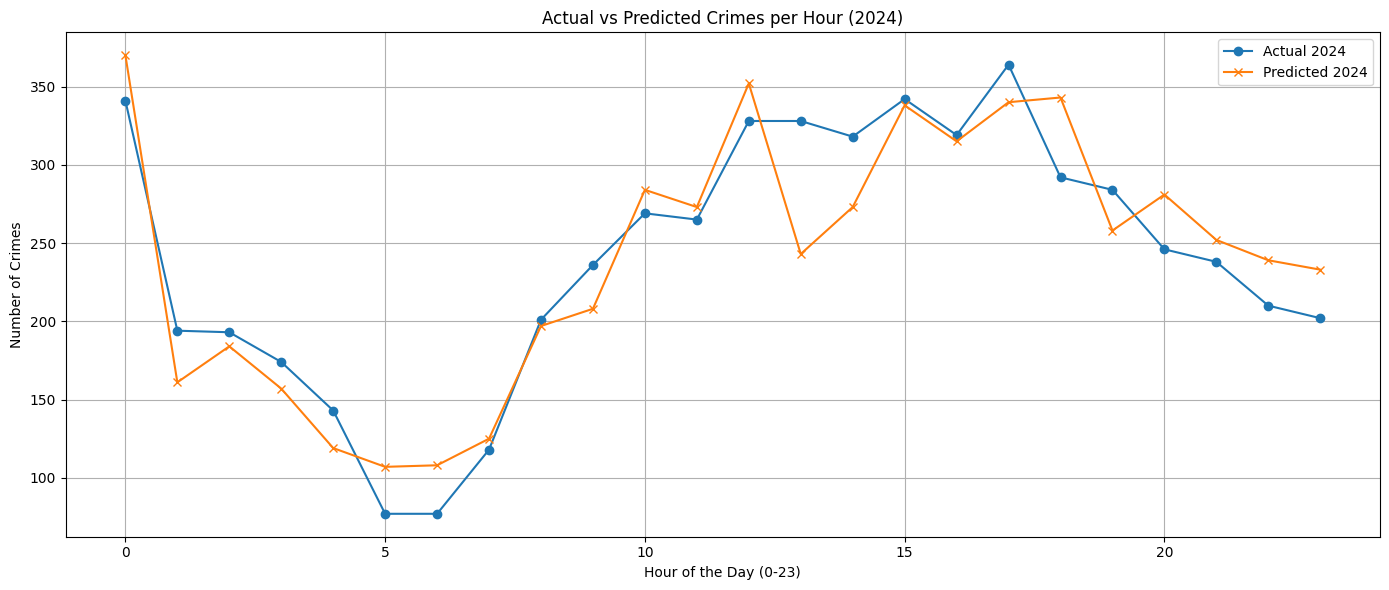

In [7]:
# --------------------------------
# 1. Import libraries
# --------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --------------------------------
# 2. Load datasets
# --------------------------------
# 2023 data (for prediction)
merged_df_2023 = pd.read_csv('/workspaces/Crime-Prediction-Analysis/Dataset/crime_df_23_un.csv')
merged_df_2023['DATEEND'] = pd.to_datetime(merged_df_2023['DATEEND'], errors='coerce')

# 2024 data (actual ground truth)
merged_df_2024 = pd.read_csv('/workspaces/Crime-Prediction-Analysis/Dataset/crime_df_24.csv')
merged_df_2024['DATEEND'] = pd.to_datetime(merged_df_2024['DATEEND'], errors='coerce')

# --------------------------------
# 3. Prepare function to extract hour
# --------------------------------
def extract_hour(timestart):
    try:
        timestart = int(timestart)
        hour = timestart // 100
        if 0 <= hour <= 23:
            return hour
        else:
            return None
    except:
        return None

# Apply on both datasets
merged_df_2023['hour'] = merged_df_2023['TIMESTART'].apply(extract_hour)
merged_df_2024['hour'] = merged_df_2024['TIMESTART'].apply(extract_hour)

# Drop missing hours
merged_df_2023 = merged_df_2023.dropna(subset=['hour'])
merged_df_2024 = merged_df_2024.dropna(subset=['hour'])

# --------------------------------
# 4. Group by hour
# --------------------------------
hourly_crimes_2023 = merged_df_2023.groupby('hour').size().reindex(range(24), fill_value=0)
hourly_crimes_2024_actual = merged_df_2024.groupby('hour').size().reindex(range(24), fill_value=0)

# --------------------------------
# 5. Predict 2024 hourly crimes (based on 2023 pattern)
# --------------------------------
# Normalize 2023 hourly pattern
hourly_percentages = hourly_crimes_2023 / hourly_crimes_2023.sum()

# Total crimes actually recorded in 2024
total_2024_actual = merged_df_2024.shape[0]

# Predicted crimes by hour
predicted_hourly_2024 = (hourly_percentages * total_2024_actual).round()

# --------------------------------
# 6. Calculate Precision Metrics
# --------------------------------
# Metrics
mae = mean_absolute_error(hourly_crimes_2024_actual, predicted_hourly_2024)
mse = mean_squared_error(hourly_crimes_2024_actual, predicted_hourly_2024)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((hourly_crimes_2024_actual - predicted_hourly_2024) / hourly_crimes_2024_actual.replace(0, np.nan))) * 100
r2 = r2_score(hourly_crimes_2024_actual, predicted_hourly_2024)

# --------------------------------
# 7. Print Results
# --------------------------------
print("\n📊 Precision Metrics (2024 prediction vs 2024 actual):")
print(f"- Mean Absolute Error (MAE): {mae:.2f}")
print(f"- Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"- Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"- R² Score: {r2:.4f}")

# --------------------------------
# 8. Plot Comparison
# --------------------------------
plt.figure(figsize=(14, 6))
plt.plot(hourly_crimes_2024_actual.index, hourly_crimes_2024_actual.values, label='Actual 2024', marker='o')
plt.plot(predicted_hourly_2024.index, predicted_hourly_2024.values, label='Predicted 2024', marker='x')
plt.title('Actual vs Predicted Crimes per Hour (2024)')
plt.xlabel('Hour of the Day (0-23)')
plt.ylabel('Number of Crimes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
# --------------------------------
# 1. Import libraries
# --------------------------------
import pandas as pd

# --------------------------------
# 2. Load datasets
# --------------------------------
# 2023 data
merged_df_2023 = pd.read_csv('/workspaces/Crime-Prediction-Analysis/Dataset/crime_df_23_un.csv')
merged_df_2023['DATEEND'] = pd.to_datetime(merged_df_2023['DATEEND'], errors='coerce')

# 2024 actual data
merged_df_2024 = pd.read_csv('/workspaces/Crime-Prediction-Analysis/Dataset/crime_df_24.csv')
merged_df_2024['DATEEND'] = pd.to_datetime(merged_df_2024['DATEEND'], errors='coerce')

# 2023+2024 combined for 2025 prediction
merged_df_2324 = pd.read_csv('/workspaces/Crime-Prediction-Analysis/Dataset/crime_df_2324_un.csv')
merged_df_2324['DATEEND'] = pd.to_datetime(merged_df_2324['DATEEND'], errors='coerce')

# --------------------------------
# 3. Extract hour from TIMESTART
# --------------------------------
def extract_hour(timestart):
    try:
        timestart = int(timestart)
        hour = timestart // 100
        if 0 <= hour <= 23:
            return hour
        else:
            return None
    except:
        return None

# Apply to all datasets
for df in [merged_df_2023, merged_df_2024, merged_df_2324]:
    df['hour'] = df['TIMESTART'].apply(extract_hour)
    df.dropna(subset=['hour'], inplace=True)

# --------------------------------
# 4. Group crimes by hour
# --------------------------------
hourly_2023_actual = merged_df_2023.groupby('hour').size().reindex(range(24), fill_value=0)
hourly_2024_actual = merged_df_2024.groupby('hour').size().reindex(range(24), fill_value=0)
hourly_2324 = merged_df_2324.groupby('hour').size().reindex(range(24), fill_value=0)

# --------------------------------
# 5. Predict hourly crimes for 2025 (based on 2023+2024 pattern)
# --------------------------------
# Normalize 2023+2024 pattern
hourly_percentage_2324 = hourly_2324 / hourly_2324.sum()

# Assume 2025 total crimes = average of 2023+2024
total_crimes_2025_estimate = merged_df_2324.shape[0] / 2

predicted_hourly_2025 = (hourly_percentage_2324 * total_crimes_2025_estimate).round()

# --------------------------------
# 6. Create Final Comparison Table
# --------------------------------
comparison_df = pd.DataFrame({
    'Actual Crimes 2023': hourly_2023_actual,
    'Actual Crimes 2024': hourly_2024_actual,
    'Predicted Crimes 2025': predicted_hourly_2025
})

print("\n📊 Hourly Crime Comparison (Actual 2023, Actual 2024, Predicted 2025):")
print(comparison_df)

# --------------------------------
# 7. (Optional) Save to CSV
# --------------------------------
comparison_df.to_csv('/workspaces/Crime-Prediction-Analysis/Dataset/hourly_crime_comparison_actual_2023_2024_predicted_2025.csv', index=True)
print("\n✅ Comparison saved to 'hourly_crime_comparison_actual_2023_2024_predicted_2025.csv'")



📊 Hourly Crime Comparison (Actual 2023, Actual 2024, Predicted 2025):
      Actual Crimes 2023  Actual Crimes 2024  Predicted Crimes 2025
hour                                                               
0                    333                 341                  337.0
1                    145                 194                  170.0
2                    166                 193                  180.0
3                    141                 174                  158.0
4                    107                 143                  125.0
5                     96                  77                   86.0
6                     97                  77                   87.0
7                    113                 118                  116.0
8                    177                 201                  189.0
9                    187                 236                  212.0
10                   256                 269                  262.0
11                   246                 265 

In [9]:
import pandas as pd
import plotly.express as px

# Load the dataset
hourly_comparison_df = pd.read_csv('/workspaces/Crime-Prediction-Analysis/Dataset/hourly_crime_comparison_actual_2023_2024_predicted_2025.csv')

# Create interactive line chart
fig = px.line(
    hourly_comparison_df,
    x='hour',
    y=['Actual Crimes 2023', 'Actual Crimes 2024', 'Predicted Crimes 2025'],
    title='Hourly Crime Comparison: 2023 Actual vs 2024 Actual vs 2025 Predicted',
    labels={'value': 'Number of Crimes', 'hour': 'Hour of Day', 'variable': 'Year'},
    markers=True
)

fig.update_layout(
    xaxis=dict(dtick=1),
    yaxis_title='Number of Crimes',
    legend_title='Legend',
    hovermode='x unified',
    template='plotly_white',
    title_font_size=20
)

fig.show()


In [10]:
# --------------------------------
# 1. Import Libraries
# --------------------------------
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import folium

# --------------------------------
# 2. Load and Prepare Data
# --------------------------------
merged_df = pd.read_csv('/workspaces/Crime-Prediction-Analysis/Dataset/crime_df_2324_un.csv')
merged_df = merged_df.dropna(subset=['LAT', 'LONG'])

# --------------------------------
# 3. Create Grid
# --------------------------------
grid_size_lat = 0.01
grid_size_lon = 0.01

min_lat, max_lat = merged_df['LAT'].min(), merged_df['LAT'].max()
min_lon, max_lon = merged_df['LONG'].min(), merged_df['LONG'].max()

lat_bins = np.arange(min_lat, max_lat + grid_size_lat, grid_size_lat)
lon_bins = np.arange(min_lon, max_lon + grid_size_lon, grid_size_lon)

merged_df['lat_bin'] = pd.cut(merged_df['LAT'], bins=lat_bins)
merged_df['lon_bin'] = pd.cut(merged_df['LONG'], bins=lon_bins)

# Group by grid
grid_features = merged_df.groupby(['lat_bin', 'lon_bin']).size().reset_index(name='crime_count')

# Center of each grid
grid_features['lat_center'] = grid_features['lat_bin'].apply(lambda x: (x.left + x.right)/2)
grid_features['lon_center'] = grid_features['lon_bin'].apply(lambda x: (x.left + x.right)/2)

# --------------------------------
# 4. Define Labels (Risk Category)
# --------------------------------
def categorize_risk(count):
    if count > 150:
        return 'High'
    elif count > 50:
        return 'Medium'
    elif count > 10:
        return 'Low'
    else:
        return 'Very Low'

grid_features['risk_label'] = grid_features['crime_count'].apply(categorize_risk)

# --------------------------------
# 5. Prepare Data for ML
# --------------------------------
X = grid_features[['lat_center', 'lon_center']]
y = grid_features['risk_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on same grid
predicted_risks_2025 = model.predict(X)
grid_features['predicted_risk_2025'] = predicted_risks_2025

# --------------------------------
# 6. Predict Number of Crimes in Each Grid
# --------------------------------
# Assume total predicted 2025 crimes = half of 2023+2024 crimes
total_crimes_2025_estimate = merged_df.shape[0] / 2

# Crime % for each grid
grid_features['crime_pct'] = grid_features['crime_count'] / grid_features['crime_count'].sum()

# Predicted crimes in each grid
grid_features['predicted_crimes_2025'] = (grid_features['crime_pct'] * total_crimes_2025_estimate).round()

# --------------------------------
# 7. Create Folium Map
# --------------------------------
map_center = [merged_df['LAT'].mean(), merged_df['LONG'].mean()]
m = folium.Map(location=map_center, zoom_start=12)

# Color map
risk_colors = {
    'High': 'red',
    'Medium': 'orange',
    'Low': 'yellow',
    'Very Low': 'green'
}

# Draw Grids
for idx, row in grid_features.iterrows():
    lat_center = row['lat_center']
    lon_center = row['lon_center']
    risk_level = row['predicted_risk_2025']
    predicted_crimes = int(row['predicted_crimes_2025'])
    
    lat_start = row['lat_bin'].left
    lat_end = row['lat_bin'].right
    lon_start = row['lon_bin'].left
    lon_end = row['lon_bin'].right
    
    folium.Rectangle(
        bounds=[[lat_start, lon_start], [lat_end, lon_end]],
        color='black',
        weight=1,
        fill=True,
        fill_color=risk_colors[risk_level],
        fill_opacity=0.5,
        popup=f"Predicted Risk: {risk_level}<br>Predicted Crimes: {predicted_crimes}"
    ).add_to(m)
    
    # Marker in center
    folium.map.Marker(
        [lat_center, lon_center],
        icon=folium.DivIcon(
            html=f"""<div style="font-size: 10px; font-weight:bold; color: black;">{predicted_crimes}</div>"""
        )
    ).add_to(m)

# --------------------------------
# 8. Save Map
# --------------------------------
m.save('/workspaces/Crime-Prediction-Analysis/HTML files/Predicted_2025_Crime_Hotspot_RF_With_Crimes.html')
print("\n✅ Predicted 2025 crime hotspot map with crime numbers saved as 'Predicted_2025_Crime_Hotspot_RF_With_Crimes.html'")


/tmp/ipykernel_61641/1297267578.py:33: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.




✅ Predicted 2025 crime hotspot map with crime numbers saved as 'Predicted_2025_Crime_Hotspot_RF_With_Crimes.html'


In [11]:
# Define grid size (tune these if needed for better resolution)
lat_step = 0.01
lon_step = 0.01

# Create grid ID
def create_grid_id(lat, lon):
    if pd.isna(lat) or pd.isna(lon):
        return None
    lat_id = int(lat // lat_step)
    lon_id = int(lon // lon_step)
    return f"G_{lat_id}_{lon_id}"


# Ensure latitude and longitude columns exist
assert 'LAT' in merged_df_2324.columns and 'LONG' in merged_df_2324.columns, "Missing lat/lon columns"

# Create grid_id column
merged_df_2324['grid_id'] = merged_df_2324.apply(lambda row: create_grid_id(row['LAT'], row['LONG']), axis=1)

# Optional: Drop rows with invalid/missing grid
merged_df_2324.dropna(subset=['grid_id'], inplace=True)

merged_df_2324.to_csv("/workspaces/Crime-Prediction-Analysis/Dataset/NEW_MERGED.csv" , index = 'FALSE')

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Step 1: Extract year from DATEEND
merged_df_2324['DATEEND'] = pd.to_datetime(merged_df_2324['DATEEND'], errors='coerce')
merged_df_2324['year'] = merged_df_2324['DATEEND'].dt.year

# Step 2: Create grid_id based on LAT/LONG
def create_grid_id(lat, lon, lat_step=0.01, lon_step=0.01):
    if pd.isna(lat) or pd.isna(lon):
        return None
    lat_id = int(lat // lat_step)
    lon_id = int(lon // lon_step)
    return f"G_{lat_id}_{lon_id}"

merged_df_2324['grid_id'] = merged_df_2324.apply(lambda row: create_grid_id(row['LAT'], row['LONG']), axis=1)
merged_df_2324.dropna(subset=['grid_id'], inplace=True)

# Step 3: Aggregate dominant crime per grid using past years (2023 & 2024)
df_train = merged_df_2324[merged_df_2324['year'].isin([2023, 2024])].copy()
dominant_crime_per_grid = df_train.groupby('grid_id')['CODE_DEFINED'].agg(lambda x: x.mode()[0]).reset_index()
dominant_crime_per_grid.columns = ['grid_id', 'dominant_crime_type']

# Step 4: Get grid-level features (mean LAT/LONG)
grid_features = df_train.groupby('grid_id')[['LAT', 'LONG']].mean().reset_index()
df_grid_train = pd.merge(dominant_crime_per_grid, grid_features, on='grid_id')

# Step 5: Encode labels
le = LabelEncoder()
df_grid_train['crime_label'] = le.fit_transform(df_grid_train['dominant_crime_type'])

# Step 6: Train model
X_train = df_grid_train[['LAT', 'LONG']]
y_train = df_grid_train['crime_label']
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Step 7: Predict for same grid locations (assuming similar 2025 conditions)
# This acts as our 2025 forecast
df_2025_grid = df_grid_train[['grid_id', 'LAT', 'LONG']].copy()
X_test = df_2025_grid[['LAT', 'LONG']]
y_pred_labels = clf.predict(X_test)
df_2025_grid['predicted_crime_type'] = le.inverse_transform(y_pred_labels)

# Final predicted output
df_2025_grid[['grid_id', 'predicted_crime_type']].head()


,grid_id,predicted_crime_type
0,G_4298_-7614,MV THEFT
1,G_4298_-7615,MV THEFT
2,G_4298_-7616,LARCENY
3,G_4299_-7614,LARCENY
4,G_4299_-7615,LARCENY


In [13]:
import folium
from folium import Popup
import branca.colormap as cm
import matplotlib.pyplot as plt

# Step 1: Assign color to each crime type
crime_types = df_2025_grid['predicted_crime_type'].unique()
color_map = plt.cm.get_cmap('tab10', len(crime_types))  # Pick 10 distinct colors
crime_color_dict = {crime: f"#{''.join([format(int(c*255), '02x') for c in color_map(i)[:3]])}" 
                    for i, crime in enumerate(crime_types)}

# Step 2: Create base map centered around Syracuse
m = folium.Map(location=[df_2025_grid['LAT'].mean(), df_2025_grid['LONG'].mean()], zoom_start=12)

# Grid size (should match what was used in grid_id creation)
lat_step = 0.01
lon_step = 0.01

# Step 3: Add rectangles for each predicted grid
for _, row in df_2025_grid.iterrows():
    lat = row['LAT']
    lon = row['LONG']
    grid_id = row['grid_id']
    crime = row['predicted_crime_type']
    color = crime_color_dict[crime]

    # Define bounds for the rectangle
    bounds = [[lat, lon], [lat + lat_step, lon + lon_step]]

    folium.Rectangle(
        bounds=bounds,
        color=color,
        fill=True,
        fill_opacity=0.6,
        popup=Popup(f"Grid: {grid_id}<br>Predicted Crime: {crime}", max_width=200)
    ).add_to(m)

# Step 4: Add legend manually
legend_html = "<div style='position: fixed; bottom: 50px; left: 50px; width: 200px; background: white; padding: 10px; border: 2px solid black;'>"
legend_html += "<b>Predicted Crime Types</b><br>"
for crime, color in crime_color_dict.items():
    legend_html += f"<i style='background:{color};width:15px;height:15px;display:inline-block;margin-right:5px;'></i>{crime}<br>"
legend_html += "</div>"
m.get_root().html.add_child(folium.Element(legend_html))

# Step 5: Save and/or display
m.save("/workspaces/Crime-Prediction-Analysis/HTML files/Predicted_2025_Crime_Type_Grid_Map.html")
print("✅ Map saved as: Predicted_2025_Crime_Type_Grid_Map.html")


✅ Map saved as: Predicted_2025_Crime_Type_Grid_Map.html


/tmp/ipykernel_61641/3419107259.py:8: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



In [14]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict on training data itself (since we don't have real 2025 labels)
y_pred_train = clf.predict(X_train)

# Evaluation
print("Accuracy on training set:", accuracy_score(y_train, y_pred_train))
print("\nClassification Report:\n", classification_report(y_train, y_pred_train, target_names=le.classes_))


Accuracy on training set: 1.0

Classification Report:
               precision    recall  f1-score   support

    BURGLARY       1.00      1.00      1.00         1
     LARCENY       1.00      1.00      1.00        74
    MV THEFT       1.00      1.00      1.00         8

    accuracy                           1.00        83
   macro avg       1.00      1.00      1.00        83
weighted avg       1.00      1.00      1.00        83



In [15]:
!pip install imbalanced-learn

In [16]:
import pandas as pd

import numpy as np

from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score, classification_report

from imblearn.over_sampling import SMOTE

import folium

from folium import Popup

import matplotlib.pyplot as plt

 

# ---------------------

# Step 1: Load Data

# ---------------------

crime_df_2324_un = pd.read_csv('/workspaces/Crime-Prediction-Analysis/Dataset/crime_df_2324_un.csv')

 

# ---------------------

# Step 2: Date Parsing & Grid Creation

# ---------------------

crime_df_2324_un['DATEEND'] = pd.to_datetime(crime_df_2324_un['DATEEND'], errors='coerce')

crime_df_2324_un['year'] = crime_df_2324_un['DATEEND'].dt.year

 

def create_grid_id(lat, lon, lat_step=0.01, lon_step=0.01):

    if pd.isna(lat) or pd.isna(lon):

        return None

    lat_id = int(lat // lat_step)

    lon_id = int(lon // lon_step)

    return f"G_{lat_id}_{lon_id}"

 

crime_df_2324_un['grid_id'] = crime_df_2324_un.apply(lambda row: create_grid_id(row['LAT'], row['LONG']), axis=1)

crime_df_2324_un.dropna(subset=['grid_id'], inplace=True)

 

# ---------------------

# Step 3: Train Data (2023) — Dominant Crime Type

# ---------------------

df_2023 = crime_df_2324_un[crime_df_2324_un['year'] == 2023].copy()

dominant_2023 = df_2023.groupby('grid_id')['CODE_DEFINED'].agg(lambda x: x.mode()[0]).reset_index()

grid_coords_2023 = df_2023.groupby('grid_id')[['LAT', 'LONG']].mean().reset_index()

train_df = pd.merge(dominant_2023, grid_coords_2023, on='grid_id')

 

# ✅ Add unemployment_rate to train_df

unemp_train = df_2023[['grid_id', 'unemployment_rate']].drop_duplicates()

train_df = pd.merge(train_df, unemp_train, on='grid_id', how='left')

train_df['unemployment_rate'].fillna(train_df['unemployment_rate'].mean(), inplace=True)

 

# ---------------------

# Step 4: Encode + Prepare Features

# ---------------------

le = LabelEncoder()

train_df['crime_label'] = le.fit_transform(train_df['CODE_DEFINED'])

 

X_train = train_df[['LAT', 'LONG', 'unemployment_rate']]

y_train = train_df['crime_label']

 

# SMOTE for class balancing

smote = SMOTE(random_state=42, k_neighbors=1)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

 

# Train classifier

clf = RandomForestClassifier(n_estimators=100, random_state=42)

clf.fit(X_train_resampled, y_train_resampled)

 

# ---------------------

# Step 5: Test Data (2024) — Prepare and Merge

# ---------------------

df_2024 = crime_df_2324_un[crime_df_2324_un['year'] == 2024].copy()

dominant_2024 = df_2024.groupby('grid_id')['CODE_DEFINED'].agg(lambda x: x.mode()[0]).reset_index()

grid_coords_2024 = df_2024.groupby('grid_id')[['LAT', 'LONG']].mean().reset_index()

test_df = pd.merge(dominant_2024, grid_coords_2024, on='grid_id')

test_df = test_df[test_df['grid_id'].isin(train_df['grid_id'])]

 

# ✅ Add unemployment_rate to test_df

unemp_test = df_2024[['grid_id', 'unemployment_rate']].drop_duplicates()

test_df = pd.merge(test_df, unemp_test, on='grid_id', how='left')

test_df['unemployment_rate'].fillna(train_df['unemployment_rate'].mean(), inplace=True)

 

X_test = test_df[['LAT', 'LONG', 'unemployment_rate']]

y_test_labels = le.transform(test_df['CODE_DEFINED'])

 

# Predict

y_pred_labels = clf.predict(X_test)

 

# ---------------------

# Step 6: Evaluation

# ---------------------

accuracy = accuracy_score(y_test_labels, y_pred_labels)

report = classification_report(y_test_labels, y_pred_labels, target_names=le.classes_)

 

print("✅ Accuracy (2023 → 2024):", round(accuracy, 3))

print("\nClassification Report:\n", report)

 

# ---------------------

# Step 7: Folium Map

# ---------------------

map_df = test_df.copy()

map_df['predicted_crime_label'] = y_pred_labels

map_df['predicted_crime_type'] = le.inverse_transform(map_df['predicted_crime_label'])

 

crime_types = map_df['predicted_crime_type'].unique()

color_map = plt.cm.get_cmap('tab10', len(crime_types))

crime_color_dict = {

    crime: f"#{''.join([format(int(c * 255), '02x') for c in color_map(i)[:3]])}"

    for i, crime in enumerate(crime_types)

}

 

m = folium.Map(location=[map_df['LAT'].mean(), map_df['LONG'].mean()], zoom_start=12)

lat_step = 0.01

lon_step = 0.01

 

for _, row in map_df.iterrows():

    lat, lon = row['LAT'], row['LONG']

    grid_id = row['grid_id']

    crime = row['predicted_crime_type']

    color = crime_color_dict[crime]

 

    bounds = [[lat, lon], [lat + lat_step, lon + lon_step]]

 

    folium.Rectangle(

        bounds=bounds,

        color=color,

        fill=True,

        fill_opacity=0.6,

        popup=Popup(f"Grid: {grid_id}<br>Predicted Crime: {crime}<br>Unemployment: {row['unemployment_rate']:.2f}%", max_width=250)

    ).add_to(m)

 

# Legend

legend_html = "<div style='position: fixed; bottom: 50px; left: 50px; width: 200px; background: white; padding: 10px; border:2px solid black;'>"

legend_html += "<b>Predicted Crime Types</b><br>"

for crime, color in crime_color_dict.items():

    legend_html += f"<i style='background:{color};width:15px;height:15px;display:inline-block;margin-right:5px;'></i>{crime}<br>"

legend_html += "</div>"

m.get_root().html.add_child(folium.Element(legend_html))

 

m.save("/workspaces/Crime-Prediction-Analysis/HTML files/hbcaudbciacoanp.html")

print("✅ Map saved as: Predicted_2024_Crime_Type_Grid_Map.html")

/tmp/ipykernel_61641/2389643490.py:85: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_61641/2389643490.py:147: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True

✅ Accuracy (2023 → 2024): 0.81

Classification Report:
               precision    recall  f1-score   support

    BURGLARY       0.00      0.00      0.00         5
     LARCENY       0.90      0.89      0.89       657
    MV THEFT       0.26      0.24      0.25        82

    accuracy                           0.81       744
   macro avg       0.39      0.38      0.38       744
weighted avg       0.82      0.81      0.82       744



/tmp/ipykernel_61641/2389643490.py:197: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



✅ Map saved as: Predicted_2024_Crime_Type_Grid_Map.html
